# CPSC 330 - Applied Machine Learning 

## Homework 5: Evaluation metrics
### Associated lectures: [Lectures 9, 10](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Feb 28, 2022 at 11:59pm**

## Imports

In [6]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Instructions 
<hr>
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has a disease or not. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 18 | 22 |
| **Actual no disease**       | 10 | 100 |


- Model B

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 23 | 17 |
| **Actual no disease**       | 20 | 90 |

### 1.1 Positive vs. negative class 
rubric={points:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

Positive would be that the patient has the disease because when we're talking about viruses/diseases/etc we usually say someone is positive if they have it. We want to spot patients that are "positive" for a certain illness.

<br><br>

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [7]:
results_dict = {"A": {}, "B": {}}

In [8]:
results_dict["A"]["accuracy"] = (18+100)/(18+100+22+10)
results_dict["B"]["accuracy"] = (23+90)/(23+90+17+20)

In [9]:
assert tests_hw5.ex1_2_1(
    results_dict["A"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [10]:
assert tests_hw5.ex1_2_2(
    results_dict["B"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [11]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.786667,0.753333


<br><br>

### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

Model A

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [12]:
results_dict["A"]["precision"] = 18 / (18 + 10)
results_dict["B"]["precision"] = 23 / (23 + 20)
results_dict["A"]["recall"] = 18 / (18 + 22)
results_dict["B"]["recall"] = 23 / (23 + 17)
results_dict["A"]["f1"] = 2 * (results_dict["A"]["precision"] * results_dict["A"]["recall"]) / (results_dict["A"]["precision"] + results_dict["A"]["recall"])
results_dict["B"]["f1"] = 2 * (results_dict["B"]["precision"] * results_dict["B"]["recall"]) / (results_dict["B"]["precision"] + results_dict["B"]["recall"])




In [13]:
assert tests_hw5.ex1_4_1(
    results_dict["A"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [14]:
assert tests_hw5.ex1_4_2(
    results_dict["B"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [15]:
assert tests_hw5.ex1_4_3(
    results_dict["A"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [16]:
assert tests_hw5.ex1_4_4(
    results_dict["B"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [17]:
assert tests_hw5.ex1_4_5(
    results_dict["A"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [18]:
assert tests_hw5.ex1_4_6(
    results_dict["B"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


Show the dataframe with all results. 

In [19]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.786667,0.753333
precision,0.642857,0.534884
recall,0.450000,0.575000
f1,0.529412,0.554217


<br><br>

### 1.5 Discussion
rubric={points:4}

**Your tasks:**
1. Which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

1. Recall is more important because it accounts for false negatives which are more damaging than false positives in medical diagnosis.
2. Model B

<br><br>

### (Optional) 1.6 
rubric={points:1}

**Your tasks:**

Provide 2 to 3 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [20]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


<br><br>

### 2.1 Distribution of target values
rubric={points:4}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

Yes, there is class imbalance (significantly more True than False for `churn`). We should deal with it because we care more about the customers who cancel their subscription.

<br><br>

### (Optional) 2.2 EDA 
rubric={points:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

<br><br>

### 2.3 Column transformer 
rubric={points:10}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

In each case, briefly explain your rationale with 1-2 sentences. You do not need an explanation for every feature, but for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

In [21]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [22]:
# check if any data needs to be imputed
df.isnull().any().any() | df.isna().any().any()

False

In [23]:
numeric_feats = [
    "account length",
    "number vmail messages",
    "total day minutes",
    "total day calls",
    "total day charge",
    "total eve minutes",
    "total eve calls",
    "total eve charge",
    "total night minutes",
    "total night calls",
    "total night charge",
    "total intl minutes",
    "total intl calls",
    "total intl charge",
    "customer service calls"
]
categorical_feats = [
    "state",
    "area code"
]
binary_feats = [
    "international plan",
    "voice mail plan"
]
drop_feats = [
    "phone number"
]
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder(handle_unknown="ignore", sparse=False))
binary_transformer = make_pipeline(OneHotEncoder(drop="if_binary", dtype="int"))

preprocessor = make_column_transformer(
    ("drop", drop_feats),
    (numeric_transformer, numeric_feats),
    (categorical_transformer, categorical_feats),
    (binary_transformer, binary_feats)
)

- I am scaling applying `StandardScaler` to all numerical features so that features at have larger numbers have similar impact to those that do not
- I am applying `OneHotEncoder` to `state` and `area code` because they are categorical features
- I am applying `OneHotEncoder` with `drop="if_binary"` to `international plan` and `voice mail plan` because they are binary features (yes/no)
- I am dropping `phone number` because it is unique to each customer and doesn't provide anything valuable for our predictions

<br><br>

### 2.4 Visualizing the transformed data 
rubric={points:4}

Fit and transform your `ColumnTransformer` on your training set. Print the first 5 rows of the transformed data as a dataframe (not numpy array). See lecture 10 for code that can get you the new column names after transforming. 

In [24]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse=False))]),
 'pipeline-3': Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(drop='if_binary', dtype='int'))])}

In [25]:
ohe_columns_cat = list(
    preprocessor.named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_feats)
)
ohe_columns_binary = list(
    preprocessor.named_transformers_["pipeline-3"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(binary_feats)
)

new_columns = numeric_feats + ohe_columns_cat + ohe_columns_binary

transformed = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
transformed.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,international plan_yes,voice mail plan_yes
1402,-0.767893,-0.587624,0.618769,-0.721211,0.618927,0.069871,-1.156734,0.069926,1.088667,0.052115,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1855,-0.843585,-0.587624,-1.293778,1.655252,-1.293517,-1.167277,-1.207278,-1.166291,-2.162302,-0.720990,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
633,0.544113,1.900976,-0.609809,0.169963,-0.609654,-2.210130,0.157417,-2.211244,0.369287,-0.463288,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1483,0.165650,-0.587624,0.998345,-0.473663,0.998611,-0.754894,0.258506,-0.755774,1.597736,0.000574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2638,0.115188,-0.587624,-0.994886,0.764078,-0.994731,1.195994,-0.246937,1.196515,0.793839,0.206736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<br><br>

### 2.5 area code feature
rubric={points:4}

The original dataset had a feature called `area code`. Let's assume we encoded this feature with one-hot encoding.

1. The area codes were numbers to begin with. Why do we want to use one-hot encoding on this feature?
2. What were the possible values of `area code`? 
3. What new feature(s) were created to replace `area code`? 

1. It's a categorical feature. Similar to a city or state.
2. 408, 415, 510
3. `area code_408`, `area code_415`, `area code_510`

<br><br>

### 2.6 Dummy classifier
rubric={points:4}

**Your tasks:**

Create a `DummyClassifier`. Report the following scoring metrics via cross-validation: accuracy, precision, recall, f1-score. Briefly comment on your results, including any warnings the code produces (2 sentences max).

In [26]:
scoring = {'accuracy'  : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall'    : make_scorer(recall_score), 
           'f1_score'  : make_scorer(f1_score)}

pipe_dc = make_pipeline(preprocessor, DummyClassifier())
pipe_dc.fit(X_train, y_train)
cv_results = cross_validate(pipe_dc, X_train, y_train, cv = 10, scoring = scoring)

pd.DataFrame(cv_results).mean()


C:\Users\Yaseen\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yaseen\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yaseen\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yaseen\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics

fit_time          0.009734
score_time        0.007485
test_accuracy     0.850407
test_precision    0.000000
test_recall       0.000000
test_f1_score     0.000000
dtype: float64

In [27]:
from sklearn.model_selection import cross_val_predict

confusion_matrix(y_train, cross_val_predict(DummyClassifier(), X_train, y_train))

# TN, FP
# FN, TP

array([[1984,    0],
       [ 349,    0]], dtype=int64)

Precision and recall are zero because there are no predicted positives. F1-score is zero because precision and recall are as well. The errors are due precision dividing by zero (0/0)

<br><br>

### 2.7 Logistic regression
rubric={points:8} 

**Your tasks:**

1. Train and score a logistic regression classifier on the dataset. 
2. Report the same metrics as in the previous part.
3. Are you satisfied with the results? Use your `DummyClassifier` results as a reference point. Discuss in a few sentences. 

In [28]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression())
pipe_lr.fit(X_train, y_train)
cv_results_lr = cross_validate(pipe_lr, X_train, y_train, cv = 10, scoring = scoring)

pd.DataFrame(cv_results_lr).mean()

fit_time          0.036303
score_time        0.007929
test_accuracy     0.855114
test_precision    0.545054
test_recall       0.188824
test_f1_score     0.277768
dtype: float64

Accuracy is similar, but we have actual values now for precision, recall, and f1-score. Although they aren't very good so I'm not satisfied.

<br><br>

### 2.8 Logistic regression with `class_weight`
rubric={points:6}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences.

In [29]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(class_weight = 'balanced'))
pipe_lr.fit(X_train, y_train)
cv_results_lr = cross_validate(pipe_lr, X_train, y_train, cv = 10, scoring = scoring)

pd.DataFrame(cv_results_lr).mean()

fit_time          0.038530
score_time        0.008266
test_accuracy     0.762089
test_precision    0.356872
test_recall       0.719160
test_f1_score     0.476015
dtype: float64

Our accuracy and precision went down, but f1-score and especially recall went up. Overall, I like the previous result better because I believe precision is more important for this model.

<br><br>

### 2.9 Hyperparameter optimization
rubric={points:10}

Now let's tune the hyperparameters of our `LogisticRegression` using `GridSearchCV` to maximize cross-validation f1 score. 

**Your tasks:**

1. Jointly optimize `C` (choose some reasonable values) and `class_weight` (`None` vs. `'balanced'`) with `GridSearchCV` and `scoring="f1"`. 
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

In [30]:
pipe_lr_tuned = make_pipeline(preprocessor, LogisticRegression())
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10, 100],
    'logisticregression__class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(pipe_lr_tuned, param_grid, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('drop',
                                                                         'drop',
                                                                         ['phone '
                                                                          'number']),
                                                                        ('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['account '
                                                                          'length',
                                                                          'number '
                                                 

In [31]:
grid_search.best_params_

{'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced'}

In [32]:
grid_search.best_score_

0.47873599874436196

<br><br>

### 2.10 Test results
rubric={points:10}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Confusion matrix. 
    - Classification report. 
    - Precision-recall curve with average precision score.     
    - ROC curve with AUC. 
3. Comment on the results.    

> Note that we are not doing it here but in real life, you would also plot confusion matrix, precision-recall curve, and ROC curve on validation data to examine errors and to choose a threshold which works for your operating point. 

C:\Users\Yaseen\miniconda3\envs\cpsc330\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


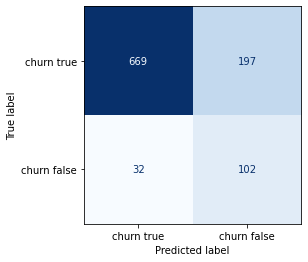

In [33]:
from sklearn.metrics import plot_confusion_matrix

pipe_lr_best = make_pipeline(preprocessor, LogisticRegression(C=0.1, class_weight='balanced'))
pipe_lr_best.fit(X_train, y_train)
predictions = pipe_lr_best.predict(X_test)
plot_confusion_matrix(
    pipe_lr_best,
    X_test,
    y_test,
    display_labels=["churn true", "churn false"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False)

In [34]:
print(
    classification_report(
        y_test, predictions, target_names=["churn true", "churn false"]
    )
)

              precision    recall  f1-score   support

  churn true       0.95      0.77      0.85       866
 churn false       0.34      0.76      0.47       134

    accuracy                           0.77      1000
   macro avg       0.65      0.77      0.66      1000
weighted avg       0.87      0.77      0.80      1000



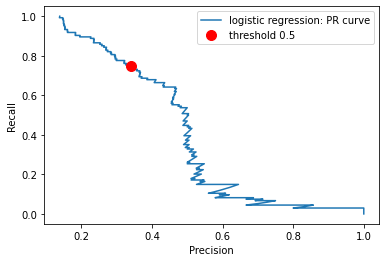

In [35]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, pipe_lr.predict_proba(X_test)[:, 1]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, pipe_lr.predict(X_test)),
    recall_score(y_test, pipe_lr.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

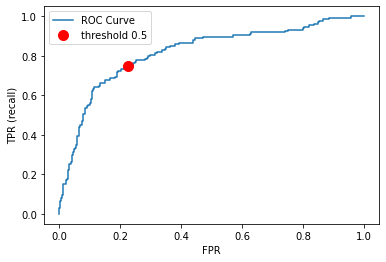

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

Adapted from Lecture 9.

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [37]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:4}

**Your tasks:**

1. Split the data into train (80%) and test (20%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` in train and test splits. 

In [38]:
train_df, test_df = train_test_split(housing_df, test_size=0.2)
train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
3336,2.5625,12.0,7.020528,1.299120,877.0,2.571848,38.82,-122.50,1.092
19216,5.3409,15.0,6.081081,1.011583,716.0,2.764479,38.48,-122.68,2.446
19367,2.3611,31.0,6.151079,1.561151,280.0,2.014388,38.46,-123.07,1.125
20538,2.8614,30.0,5.101852,0.970679,1623.0,2.504630,38.56,-121.73,1.452
14963,6.5645,31.0,6.607973,0.930233,805.0,2.674419,32.76,-117.00,1.891
...,...,...,...,...,...,...,...,...,...
16862,4.2262,37.0,4.362369,0.958188,878.0,3.059233,37.63,-122.41,2.285
2574,2.1101,34.0,5.607330,1.099476,1056.0,2.764398,40.78,-124.13,0.869
19516,1.3036,52.0,9.136364,1.590909,74.0,3.363636,37.64,-121.01,0.750
17941,4.7500,37.0,5.235632,0.945402,845.0,2.428161,37.33,-121.94,2.511


In [39]:
X_train = train_df.drop(columns=["MedHouseVal"])
X_test = test_df.drop(columns=["MedHouseVal"])

y_train = train_df["MedHouseVal"]
y_test = test_df["MedHouseVal"]

In [40]:
numeric_feats = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude",
]
numeric_transformer = make_pipeline(StandardScaler())
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_feats),
)

<br><br>

### 3.2 Baseline: DummyRegressor 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `DummyRegressor` with default scoring. 
2. What metric is used for scoring by default? 

In [41]:
pipe_dc = make_pipeline(preprocessor, DummyRegressor())
pipe_dc.fit(X_train, y_train)
cv_results = cross_validate(pipe_dc, X_train, y_train, cv = 10, return_train_score=True)

pd.DataFrame(cv_results).mean()

fit_time       0.005286
score_time     0.001795
test_score    -0.000551
train_score    0.000000
dtype: float64

The coefficient of determination R^2 of the prediction.

<br><br>

### 3.3 Different regressors
rubric={points:8}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [42]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [43]:
pipe_ridge = make_pipeline(preprocessor, models['Ridge'])
pipe_rf = make_pipeline(preprocessor, models['Random Forest'])

pipe_ridge.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

cv_results_ridge = cross_validate(pipe_ridge, X_train, y_train, cv=10, scoring=score_types_reg)
cv_results_rf = cross_validate(pipe_rf, X_train, y_train, cv=10, scoring=score_types_reg)

In [45]:
pd.DataFrame(cv_results_ridge).mean()

fit_time                             0.007084
score_time                           0.003485
test_neg_mean_squared_error         -0.686102
test_neg_root_mean_squared_error    -0.797815
test_neg_mean_absolute_error        -0.534066
test_r2                              0.487081
test_mape_scorer                   -31.878770
dtype: float64

In [46]:
pd.DataFrame(cv_results_rf).mean()

fit_time                             6.568641
score_time                           0.050420
test_neg_mean_squared_error         -0.257638
test_neg_root_mean_squared_error    -0.507228
test_neg_mean_absolute_error        -0.332325
test_r2                              0.805420
test_mape_scorer                   -18.789159
dtype: float64

These are much better than our baseline model. The RandomForestRegressor in particular seems to be performing well with different metrics.

<br><br>

### (Optional) 3.4 Hyperparameter optimization 
rubric={points:1}

**Your tasks:**
1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose the metric of your choice for hyperparameter optimization. 
2. Are you getting better scores compared to the default values?

In [48]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

In [63]:
pipe_ridge_tuned = make_pipeline(preprocessor, Ridge())
random_search = RandomizedSearchCV(pipe_ridge_tuned, param_dist, scoring='r2', n_jobs=-1)
random_search.fit(X_train, y_train)
random_search

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MedInc',
                                                                                'HouseAge',
                                                                                'AveRooms',
                                                                                'AveBedrms',
                                                                                'Population',
                                                                                'AveOccup',
                                                          

In [65]:
random_search.best_params_

{'ridge__alpha': 0.016622823211292354}

In [66]:
random_search.best_score_

0.5029959913838737

In [67]:
pipe_rf_tuned = make_pipeline(preprocessor, Ridge())
random_search = RandomizedSearchCV(pipe_rf_tuned, param_dist, scoring='r2', n_jobs=-1)
random_search.fit(X_train, y_train)
random_search

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MedInc',
                                                                                'HouseAge',
                                                                                'AveRooms',
                                                                                'AveBedrms',
                                                                                'Population',
                                                                                'AveOccup',
                                                          

In [68]:
random_search.best_params_

{'ridge__alpha': 0.0010893556624101298}

In [69]:
random_search.best_score_

0.502996248197087

The scores are worse compared to the default values.

<br><br>

### 3.5 Test results
rubric={points:4}

**Your tasks:**

1. Try the best model on the test set.
2. Briefly comment on the results. (1 to 2 sentences) 

In [75]:
predictions_rf = pipe_rf.predict(X_test)
pipe_rf.score(X_test, y_test)

0.8033489359666067

This score is in line with what we've seen in cross validation.

<br><br>

### 3.6 Model interpretation  
rubric={points:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Visualize coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. If you attempted 3.4, use the `Ridge` model with best hyperparameters. Otherwise use the `Ridge` model with default hyperparameters. 
2. Increasing which feature values would result in higher housing price? 

In [81]:
pipe_ridge = make_pipeline(preprocessor, Ridge(alpha='0.016622823211292354'))
pipe_ridge.fit(X_train, y_train)

df_coeffs = pd.DataFrame(
    data={
        "features": numeric_feats,
        "coefficients": pipe_ridge.named_steps["ridge"].coef_,
    }
)
df_coeffs.sort_values("coefficients", ascending=False)

,features,coefficients
0,MedInc,0.825425
3,AveBedrms,0.291482
1,HouseAge,0.118348
4,Population,-0.006181
5,AveOccup,-0.042156
2,AveRooms,-0.261169
7,Longitude,-0.872242
6,Latitude,-0.900531


Adapted from lecture 10.

Increasing `MedInc`, `AveBedrms`, and `HouseAge` would result in higher housing price.

<br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 